In [18]:
%matplotlib inline

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import osmnx # For querying OSM using shapefiles
from shapely import intersection
from shapely.ops import unary_union # To combine multiple shapefiles into one

pd.options.display.max_seq_items = 2000
pd.set_option('expand_frame_repr', True)
pd.set_option('display.max_colwidth', 150)
default_font_size = plt.rcParams['font.size']

# Two crs, one for coordinates and a projected one to compute areas
crs_geographical = "epsg:4326"
crs_projected = "epsg:28992"

# Labels for the five cities, so they're always in the same order
labels = ["Amsterdam", "Utrecht", "Den Haag", "Tilburg", "Groningen"]

In [2]:
# Load the CBS buurtkaart into a GeoDataFrame
path = '/home/levi/Studie/AI_jaar_2/UC/UC_Project/WijkBuurtkaart_2020_v3/buurt_2020_v3.shp'
columns = ["BU_CODE", "BU_NAAM", "GM_NAAM",                                     # For matching with BuurtAtlas
           "P_00_14_JR", 'P_15_24_JR','P_25_44_JR','P_45_64_JR', 'P_65_EO_JR',  # Age distribution
           'P_LAAGINKP', 'BEV_DICHTH', 'WWB_UITTOT', 'WW_UIT_TOT', 'AO_UIT_TOT' # Other confounders
           ]

gdf = gpd.read_file(path, include_fields=columns)
gdf.loc[gdf["GM_NAAM"] == "\'s-Gravenhage", "GM_NAAM"] = "Den Haag"

# Select the relevant rows
gdf = gdf.query("GM_NAAM=='Amsterdam' or GM_NAAM=='Tilburg' or GM_NAAM=='Den Haag' or GM_NAAM=='Groningen' or GM_NAAM=='Utrecht'")

dropped = len(gdf)
# Drop rows with missing values, which have a value of -9999
for name in ["P_00_14_JR", 'P_15_24_JR','P_25_44_JR','P_45_64_JR', 'P_65_EO_JR', 'P_LAAGINKP', 'BEV_DICHTH', 'WWB_UITTOT', 'WW_UIT_TOT', 'AO_UIT_TOT']:
    gdf.drop(gdf[gdf[name] < -1000].index, inplace=True)
dropped = dropped - len(gdf)
print(f"Dropped {dropped} neighborhoods with missing data, there are {len(gdf)} neighborhoods left.")

# Create separeate GeoDataFrames for blue and green space
gdf_blue = gpd.GeoDataFrame(gdf[["BU_CODE", "BU_NAAM", "GM_NAAM"]].copy())
gdf_blue['geometry'] = np.nan
gdf_blue.set_geometry("geometry")
gdf_blue.set_crs(crs_geographical, inplace=True)

gdf_green = gpd.GeoDataFrame(gdf[["BU_CODE", "BU_NAAM", "GM_NAAM"]].copy())
gdf_green['geometry'] = np.nan
gdf_green.set_geometry("geometry")
gdf_green.set_crs(crs_geographical, inplace=True)

# Transfrom the buurtkaart to regular coordinates
gdf.to_crs(crs_geographical, inplace=True)

# Features that can be considered blue space
blue_features = {
    'natural': 'water'
}

# Features that can be considered green space
green_features = {
    'landuse': 'recreation_ground',
    'landuse': 'village_green',
    'landuse': 'grass',
    'landuse': 'forest', 
    'landuse': 'flowerbed',
    'landuse': 'meadow',
    'leisure': 'garden',
    'leisure': "park",
    'natural': 'tree',
    'natural': 'tree_row',
    'natural': 'scrub',
    'natural': 'wood',
    'natural': 'heath',
    'natural': 'grassland',
    "barrier": 'hedge'
}

# Get water and greenspace for all neighborhoods 
cnt = 0
no_blue_count = 0
no_green_count = 0
for i, row in gdf.iterrows():
    
    print(f"{cnt}/{len(gdf)-1}", end='\r')
    cnt += 1

    try:
        # Get the bluespace for this neighborhood from OSM
        blue = osmnx.features.features_from_polygon(row["geometry"], blue_features)

        # Use shapely union to combine the geometries into one multipolygon
        l = []
        for unit in blue["geometry"]:
            l.append(unit)

        neighborhood_blue = intersection(row["geometry"], unary_union(l))
        gdf_blue.loc[i, "geometry"] = neighborhood_blue

    except osmnx._errors.InsufficientResponseError:
        # If there is no bluespace, osmnx throws an error
        no_blue_count += 1
    
    try:
        # Get the greenspace for this neighborhood from OSM
        green = osmnx.features.features_from_polygon(row["geometry"], green_features)
       
        # Use shapely union to combine the geometries into one multipolygon
        l = []
        for unit in green["geometry"]:
            l.append(unit)

        neighborhood_green = intersection(row["geometry"], unary_union(l))
        gdf_green.loc[i, "geometry"] = neighborhood_green

    except osmnx._errors.InsufficientResponseError:
        # If ther eis no greenspace, osmnx throws an error
        no_green_count += 1
    
print(f"{no_blue_count} neighborhoods have no bluespace at all")
print(f"{no_green_count} neighborhoods have no greenspace at all")


Dropped 209 neighborhoods with missing data, there are 899 neighborhoods left.


/tmp/ipykernel_24391/2343422835.py:23: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_blue['geometry'] = np.nan
/tmp/ipykernel_24391/2343422835.py:28: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  gdf_green['geometry'] = np.nan


125 neighborhoods have no bluespace at all
221 neighborhoods have no greenspace at all


In [3]:
# Save and load to not have to do the above over and over again
# Set the crs for the blue and green space GeoDataFrames
gdf_blue.to_crs(crs_geographical, inplace=True)
gdf_green.to_crs(crs_geographical, inplace=True)

# Check if the crs is correct (should be epsg:4326)
print(gdf.crs)
print(gdf_blue.crs)
print(gdf_green.crs)

# Save the data
gdf.to_csv("data/gdf_temp.csv", index=True)
gdf_blue.to_csv("data/gdf_blue_temp.csv", index=True)
gdf_green.to_csv("data/gdf_green_temp.csv", index=True)

epsg:4326
epsg:4326
epsg:4326


## TIP: Run these cells in order!
Throughout this notebook, the GeoDataFrames are switched between two different crs. If you run the below cells out of order, things may break becase the data is in the wrong format. 

In [4]:
# If the above two cells were execute before, they can be skipped by reading the result files instead
gdf = gpd.read_file("data/gdf_temp.csv", 
                    GEOM_POSSIBLE_NAMES="geometry", # Having a column named 'geometry' is too hard for geopandas
                    KEEP_GEOM_COLUMNS="NO").set_index('field_1')
gdf_blue = gpd.read_file("data/gdf_blue_temp.csv", 
                    GEOM_POSSIBLE_NAMES="geometry", # Having a column named 'geometry' is too hard for geopandas
                    KEEP_GEOM_COLUMNS="NO").set_index('field_1')
gdf_green = gpd.read_file("data/gdf_green_temp.csv", 
                    GEOM_POSSIBLE_NAMES="geometry", # Having a column named 'geometry' is too hard for geopandas
                    KEEP_GEOM_COLUMNS="NO").set_index('field_1')

# Validate that the CRS is correct
print(gdf.head(1)["geometry"])
print(gdf_blue.head(1)["geometry"])
print(gdf_green.head(1)["geometry"])

# Set the correct crs
gdf.set_crs(crs_geographical, inplace=True, allow_override=True)
gdf_blue.set_crs(crs_geographical, inplace=True, allow_override=True)
gdf_green.set_crs(crs_geographical, inplace=True, allow_override=True)

# Check crs
print(gdf.crs)
print(gdf_blue.crs)
print(gdf_green.crs)

field_1
149    POLYGON ((6.56757 53.22222, 6.56840 53.22200, 6.57009 53.22149, 6.57039 53.22138, 6.57072 53.22110, 6.57192 53.21987, 6.57274 53.21846, 6.57243 53...
Name: geometry, dtype: geometry
field_1
149    POLYGON ((6.56840 53.22200, 6.57009 53.22149, 6.57039 53.22138, 6.57072 53.22110, 6.57192 53.21987, 6.57274 53.21846, 6.57252 53.21847, 6.57251 53...
Name: geometry, dtype: geometry
field_1
149    GEOMETRYCOLLECTION (LINESTRING (6.56868 53.22128, 6.56870 53.22128, 6.56863 53.22120, 6.56867 53.22119, 6.56866 53.22118), LINESTRING (6.56894 53....
Name: geometry, dtype: geometry
epsg:4326
epsg:4326
epsg:4326


In [5]:
# gdf.to_crs(crs_geographical, inplace=True)
# gdf_blue.to_crs(crs_geographical, inplace=True)
# gdf_green.to_crs(crs_geographical, inplace=True)

# print(gdf.crs)
# print(gdf_blue.crs)
# print(gdf_green.crs)

# print(gdf.head(1)["geometry"])
# print(gdf_blue.head(1)["geometry"])
# print(gdf_green.head(1)["geometry"])

# # Visualise some information
# gdf.info()
# gdf.head(5)
# gdf.columns


In [6]:
# Visualise the blue- and greenspace

plt.rcParams.update({'font.size': 18})

fig, axes = plt.subplots(1, 5, figsize=(25,5))
for i in range(5):
    ax = axes[i]
    label = labels[i]
    gdf[gdf["GM_NAAM"] == label].plot(ax=ax, color="grey")
    gdf_blue[gdf_blue["GM_NAAM"] == label].plot(ax=ax, color="blue")
    bounds = gdf[gdf["GM_NAAM"] == label].total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_xlabel("Long")
    ax.set_ylabel("Lat")
    ax.set_title(f"Bluespace in {label}")

fig.tight_layout()
plt.savefig("Bluespace.png", dpi=300)
plt.clf()

fig, axes = plt.subplots(1, 5, figsize=(25,5))
for i in range(5):
    ax = axes[i]
    label = labels[i]
    gdf[gdf["GM_NAAM"] == label].plot(ax=ax, color="grey")
    gdf_green[gdf_green["GM_NAAM"] == label].plot(ax=ax, color="Green")
    bounds = gdf[gdf["GM_NAAM"] == label].total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_xlabel("Long")
    ax.set_ylabel("Lat")
    ax.set_title(f"Greenspace in {label}")

fig.tight_layout()
plt.savefig("Greenspace.png", dpi=300)
plt.clf()

fig, axes = plt.subplots(1, 5, figsize=(25,5))
for i in range(5):
    ax = axes[i]
    label = labels[i]
    gdf[gdf["GM_NAAM"] == label].plot(ax=ax, color="grey")
    gdf_green[gdf_green["GM_NAAM"] == label].plot(ax=ax, color="Green")
    gdf_blue[gdf_blue["GM_NAAM"] == label].plot(ax=ax, color="blue")
    bounds = gdf[gdf["GM_NAAM"] == label].total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_xlabel("Long")
    ax.set_ylabel("Lat")
    ax.set_title(f"{label}")

fig.tight_layout()
plt.savefig("Bluegreenspace.png", dpi=300)
plt.clf()

plt.rcParams.update({'font.size': default_font_size})


<Figure size 2500x500 with 0 Axes>

<Figure size 2500x500 with 0 Axes>

<Figure size 2500x500 with 0 Axes>

In [7]:
# Transform coordinates to projection with accurate area 
gdf.to_crs(crs_projected, inplace=True)
print(gdf.crs)
gdf_green.to_crs(crs_projected, inplace=True)
print(gdf.crs)
gdf_blue.to_crs(crs_projected, inplace=True)
print(gdf.crs)

print()

# Check the format, the unit should be meters now
print(gdf.head(1)["geometry"])
print(gdf_blue.head(1)["geometry"])
print(gdf_green.head(1)["geometry"])


epsg:28992
epsg:28992
epsg:28992

field_1
149    POLYGON ((233836.217 582380.178, 233892.194 582356.310, 234005.895 582302.135, 234025.630 582289.961, 234048.209 582259.008, 234131.166 582123.210...
Name: geometry, dtype: geometry
field_1
149    POLYGON ((233892.194 582356.310, 234005.895 582302.135, 234025.630 582289.961, 234048.209 582259.008, 234131.166 582123.210, 234188.240 581967.601...
Name: geometry, dtype: geometry
field_1
149    GEOMETRYCOLLECTION (LINESTRING (233912.000 582277.500, 233913.179 582276.930, 233908.948 582268.490, 233911.219 582267.280, 233910.591 582266.090)...
Name: geometry, dtype: geometry


In [8]:
# Calculate the area of a geometry
def calc_area(geo):
    if geo is not None:
        return geo.area
    else:
        return 0

# Execute for every polygon
gdf["area"] = gdf.apply(lambda row: calc_area(row["geometry"]), axis=1)
gdf_blue["area"] = gdf_blue.apply(lambda row: calc_area(row["geometry"]), axis=1)
gdf_green["area"] = gdf_green.apply(lambda row: calc_area(row["geometry"]), axis=1)

# Calculate the percentage of blue- and greenspace
gdf["percent_blue"] = gdf_blue["area"] / gdf["area"]
gdf["percent_green"] = gdf_green["area"] / gdf["area"]

gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 899 entries, 149 to 9038
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   BU_CODE        899 non-null    object  
 1   BU_NAAM        899 non-null    object  
 2   GM_NAAM        899 non-null    object  
 3   BEV_DICHTH     899 non-null    object  
 4   P_00_14_JR     899 non-null    object  
 5   P_15_24_JR     899 non-null    object  
 6   P_25_44_JR     899 non-null    object  
 7   P_45_64_JR     899 non-null    object  
 8   P_65_EO_JR     899 non-null    object  
 9   P_LAAGINKP     899 non-null    object  
 10  AO_UIT_TOT     899 non-null    object  
 11  WW_UIT_TOT     899 non-null    object  
 12  WWB_UITTOT     899 non-null    object  
 13  geometry       899 non-null    geometry
 14  area           899 non-null    float64 
 15  percent_blue   899 non-null    float64 
 16  percent_green  899 non-null    float64 
dtypes: float64(3), geometry(1), o

In [9]:
# Set the geographies back into normal coordinates
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)
gdf.to_crs(crs_geographical, inplace=True)
print(gdf.crs)

epsg:4326
epsg:4326
epsg:4326


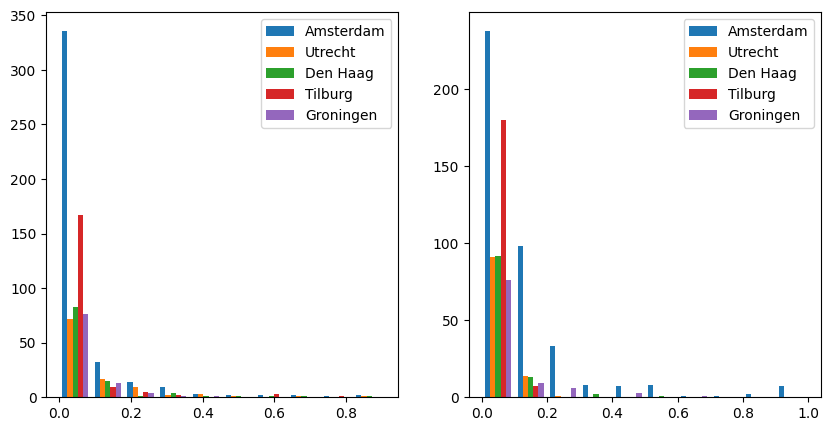

In [10]:
# Visualise the distibution of green- and bluespace
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_green"])
ax1.hist(to_plot, bins=10, histtype="bar", label=labels)
ax1.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_blue"])
ax2.hist(to_plot, bins=10, histtype="bar", label=labels)
ax2.legend()


plt.show()

In [11]:
# Load Depression risk data fromm buurtatlas
path_buurtatlas = '/home/levi/Studie/AI_jaar_2/UC/UC_Project/data/Gezondheid_per_wijk_en_buurt__2012_2016_2020_2022__indeling_2022__11122023_140527.csv'
df_buurtatlas = pd.read_csv(path_buurtatlas, header=6, delimiter=';')
df_buurtatlas.rename(columns={"Wijken en buurten": "BU_NAAM", "naam": "GM_NAAM", "%": "DEPRESSION_RISK"}, inplace=True)
df_buurtatlas.drop_duplicates(["BU_NAAM", "GM_NAAM"] ,inplace=True)
df_buurtatlas.loc[df_buurtatlas["GM_NAAM"] == "\'s-Gravenhage", "GM_NAAM"] = "Den Haag"
df_buurtatlas.info()

# Rename some buurten so both dataframes understand it
gdf.loc[gdf["BU_NAAM"] == "BelgiÃ«plein e.o.", "BU_NAAM"] = "Belgiëplein e.o."
gdf.loc[gdf["BU_NAAM"] == "Egelantierstraat, MariÃ«ndaalstraat e.o.", "BU_NAAM"] = "Egelantierstraat, Mariëndaalstraat e.o."
gdf.loc[gdf["BU_NAAM"] == "Breedstraat en Plompetorengracht en omgeving", "BU_NAAM"] = "Breedstraat en Plompetorengracht e.o."
gdf.loc[gdf["BU_NAAM"] == "Lange Elisabethstraat, Mariaplaats en omgeving", "BU_NAAM"] = "Lange Elisabethstraat, Mariaplaats e.o."
gdf.loc[gdf["BU_NAAM"] == "MÃ¡ximapark", "BU_NAAM"] = "Máximapark"
gdf.loc[gdf["BU_NAAM"] == "Nieuw Engeland, Th. a. Kempisplantsoen en omgeving", "BU_NAAM"] = "Nieuw Engeland, Th. a. Kempisplantsoen e"
gdf.loc[gdf["BU_NAAM"] == "Zeeheldenbuurt, Hengeveldstraat en omgeving", "BU_NAAM"] = "Zeeheldenbuurt, Hengeveldstraat e.o."

df_buurtatlas.info()
df_buurtatlas.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 0 to 1345
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   BU_NAAM          1333 non-null   object
 1   GM_NAAM          1332 non-null   object
 2   DEPRESSION_RISK  1332 non-null   object
dtypes: object(3)
memory usage: 41.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1333 entries, 0 to 1345
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   BU_NAAM          1333 non-null   object
 1   GM_NAAM          1332 non-null   object
 2   DEPRESSION_RISK  1332 non-null   object
dtypes: object(3)
memory usage: 41.7+ KB


,BU_NAAM,GM_NAAM,DEPRESSION_RISK
0,Amsterdam,Amsterdam,"9,4"
1,Burgwallen-Oude Zijde,Amsterdam,"8,8"
2,Kop Zeedijk,Amsterdam,"8,2"
3,Oude Kerk e.o.,Amsterdam,"9,4"
4,Burgwallen Oost,Amsterdam,"9,2"


In [12]:
# Compare the names of BuurtAtlas and CBS 
names_cbs = gdf.sort_values("BU_NAAM")["BU_NAAM"].unique()
names_ba = df_buurtatlas.sort_values("BU_NAAM")["BU_NAAM"].unique()

# If this provides no output, every buurt in the gdf has a matching buurtatlas entry
for i in range(len(names_cbs)):
    if names_cbs[i] not in names_ba:
        print(f"{names_cbs[i]} is not found in the buurtatlas names")

In [13]:
# Merge the two dataframes
gdf = gdf.merge(df_buurtatlas, on=["BU_NAAM", "GM_NAAM"], how="left")

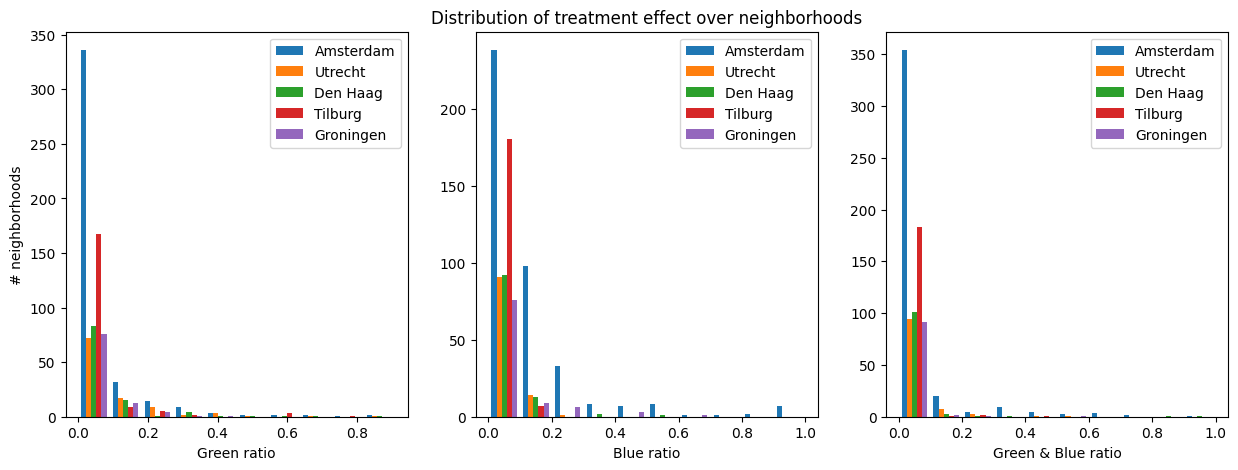

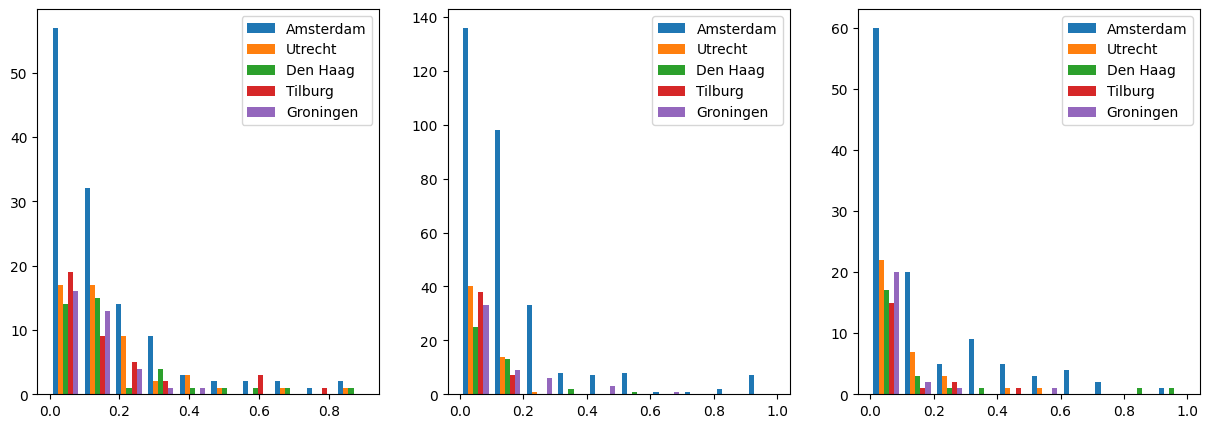

In [14]:
# Calculate the green*blue feature
gdf["percent_greenblue"] = gdf["percent_blue"] * gdf["percent_green"]
gdf["percent_greenblue"] = (gdf["percent_greenblue"] - gdf["percent_greenblue"].min()) / (gdf["percent_greenblue"].max() - gdf["percent_greenblue"].min())

nbins = 10

# Visualise the distibution of green- and bluespace
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
labels = ["Amsterdam", "Utrecht", "Den Haag", "Tilburg", "Groningen"]

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_green"])
ax1.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax1.set_ylabel("# neighborhoods")
ax1.set_xlabel("Green ratio")
ax1.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_blue"])
ax2.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax2.set_xlabel("Blue ratio")
ax2.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf[gdf["GM_NAAM"] == label]["percent_greenblue"])
ax3.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax3.set_xlabel("Green & Blue ratio")
ax3.legend()

ax2.set_title("Distribution of treatment effect over neighborhoods")
plt.show()

# Drop neighborhoods with a low percentage of green- and bluespace
# This is not used in the paper, but may be useful in the future 
drop_frac = 0.9
gdf_more_green = gdf.drop(gdf[gdf["percent_green"] < 0.05].sample(frac = drop_frac).index).dropna()
gdf_more_blue = gdf.drop(gdf[gdf["percent_blue"] < 0.05].sample(frac = drop_frac).index).dropna()
gdf_more_greenblue = gdf.drop(gdf[gdf["percent_greenblue"] < 0.05].sample(frac = drop_frac).index).dropna()


# Visualise the distibution of green- and bluespace when many low neighborhoods are omitted
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))
labels = ["Amsterdam", "Utrecht", "Den Haag", "Tilburg", "Groningen"]

to_plot = []
for label in labels:
    to_plot.append(gdf_more_green[gdf_more_green["GM_NAAM"] == label]["percent_green"])
ax1.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax1.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf_more_blue[gdf_more_blue["GM_NAAM"] == label]["percent_blue"])
ax2.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax2.legend()

to_plot = []
for label in labels:
    to_plot.append(gdf_more_greenblue[gdf_more_greenblue["GM_NAAM"] == label]["percent_greenblue"])
ax3.hist(to_plot, bins=nbins, histtype="bar", label=labels)
ax3.legend()

plt.show()


In [15]:
gdf = gdf.drop(gdf[gdf["DEPRESSION_RISK"]=="."].index).dropna("index")

# Save the final datasets
gdf_blue.to_csv("data/blue_geometries.csv")
gdf_green.to_csv("data/green_geometries.csv")
gdf.to_csv("data/prepared_data.csv")
gdf_more_green.to_csv("data/prepared_data_more_green.csv")
gdf_more_blue.to_csv("data/prepared_data_more_blue.csv")
gdf_more_greenblue.to_csv("data/prepared_data_more_greenblue.csv")

gdf.info()
gdf["GM_NAAM"].value_counts()

/tmp/ipykernel_24391/1580920428.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  gdf = gdf.drop(gdf[gdf["DEPRESSION_RISK"]=="."].index).dropna("index")


<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 899 entries, 0 to 898
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   BU_CODE            899 non-null    object  
 1   BU_NAAM            899 non-null    object  
 2   GM_NAAM            899 non-null    object  
 3   BEV_DICHTH         899 non-null    object  
 4   P_00_14_JR         899 non-null    object  
 5   P_15_24_JR         899 non-null    object  
 6   P_25_44_JR         899 non-null    object  
 7   P_45_64_JR         899 non-null    object  
 8   P_65_EO_JR         899 non-null    object  
 9   P_LAAGINKP         899 non-null    object  
 10  AO_UIT_TOT         899 non-null    object  
 11  WW_UIT_TOT         899 non-null    object  
 12  WWB_UITTOT         899 non-null    object  
 13  geometry           899 non-null    geometry
 14  area               899 non-null    float64 
 15  percent_blue       899 non-null    float64 
 16  

Amsterdam    403
Tilburg      187
Den Haag     108
Utrecht      106
Groningen     95
Name: GM_NAAM, dtype: int64

In [26]:
# Visualise the distribution of depression risk over the five cities
if gdf["DEPRESSION_RISK"].dtypes != "float64":
    gdf["DEPRESSION_RISK"] = gdf["DEPRESSION_RISK"].str.replace(',','.')
    gdf["DEPRESSION_RISK"] = gdf["DEPRESSION_RISK"].astype('float')

gdf.to_crs(crs_geographical, inplace=True)

plt.rcParams.update({'font.size': 16})

fig, axes = plt.subplots(1, 5, figsize=(25,5))
for i in range(5):
    ax = axes[i]
    label = labels[i]
    gdf[gdf["GM_NAAM"] == label].plot(ax=ax, 
         column="DEPRESSION_RISK", 
         cmap="cividis", 
         legend=True,
         legend_kwds={"label": "Risk (%)", "orientation": "horizontal"},
         )
    bounds = gdf[gdf["GM_NAAM"] == label].total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_xlabel("Long")
    ax.set_ylabel("Lat")
    ax.set_title(f"{label}")


fig.tight_layout()
plt.savefig("Depression_risk_distribution.png", dpi=300)
plt.clf()

plt.rcParams.update({'font.size': default_font_size})


<Figure size 2500x500 with 0 Axes>

In [25]:
# Visualise the distribution of a confounder over the five cities
# columns = ["P_00_14_JR", 'P_15_24_JR','P_25_44_JR','P_45_64_JR', 'P_65_EO_JR', 'P_LAAGINKP', 'BEV_DICHTH', 'WWB_UITTOT', 'WW_UIT_TOT', 'AO_UIT_TOT']

plt.rcParams.update({'font.size': 16})

conf = "P_LAAGINKP"

if gdf[conf].dtypes != "float64":
    gdf[conf] = gdf[conf].astype('float')

gdf.to_crs(crs_geographical, inplace=True)

fig, axes = plt.subplots(1, 5, figsize=(25,5))
for i in range(5):
    ax = axes[i]
    label = labels[i]
    gdf[gdf["GM_NAAM"] == label].plot(ax=ax, 
         column=conf, 
         cmap="cividis", 
         legend=True,
         legend_kwds={"label": "% of households with low income", "orientation": "horizontal"},
         )
    bounds = gdf[gdf["GM_NAAM"] == label].total_bounds
    ax.set_xlim(bounds[0], bounds[2])
    ax.set_ylim(bounds[1], bounds[3])
    ax.set_xlabel("Long")
    ax.set_ylabel("Lat")
    ax.set_title(f"{label}")

fig.tight_layout()
plt.savefig("Low_income_distribution.png", dpi=300)
plt.clf()

plt.rcParams.update({'font.size': default_font_size})


<Figure size 2500x500 with 0 Axes>